# **Retinal Vessel Segmentation Using U-Net**

## Install necessary libraries and models

In [ ]:
!pip install -q git+https://github.com/qubvel/segmentation_models.git
#!pip install -q -U keras tensorflow
!pip install -q albumentations

  Preparing metadata (setup.py) ... done


## Import necessary libraries and moels

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import segmentation_models as sm
from glob import glob
import random
import pandas as pd
from datetime import datetime
from skimage import exposure, filters, io, color
import albumentations as A
import math

In [ ]:
# Set memory growth to avoid OOM errors
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [ ]:
# Global configurations
RETINA_PATH = "/kaggle/input/retinasegmentation/retina"
MASK_PATH = "/kaggle/input/retinasegmentation/mask"
MODEL_PATH = "models"
BACKBONE = "efficientnetb7"  # Changed from efficientnetb3 to efficientnetb7 for better performance
INPUT_SHAPE = (512, 512, 3)
BATCH_SIZE = 4
EPOCHS = 100  # Increased from 50 to 100
INITIAL_LEARNING_RATE = 1e-3  # Increased initial learning rate
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2
PREPROCESSING = "CLAHE"  # Options: None, CLAHE, Gaussian, Histogram_equalization

In [ ]:
# Initialize segmentation models
sm.set_framework('tf.keras')

In [ ]:
# Make sure necessary directories exist
def make_dirs():
    """Create necessary directories"""
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    print(f"Directory {MODEL_PATH} is ready")

## Helper Functions

In [ ]:
# Data loading functions
def load_data(retina_path, mask_path):
    """Load the dataset and return lists of image paths"""
    retina_images = sorted(glob(os.path.join(retina_path, "*.png")))
    mask_images = sorted(glob(os.path.join(mask_path, "*.png")))

    if not retina_images or not mask_images:
        raise Exception(f"No images found in {retina_path} or {mask_path}")

    print(f"Total images found: {len(retina_images)}")
    return retina_images, mask_images

def split_dataset(retina_images, mask_images, train_ratio=0.8):
    """Split the dataset into training and validation sets"""
    X_train, X_val, y_train, y_val = train_test_split(
        retina_images, mask_images, test_size=1-train_ratio, random_state=42
    )
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    return X_train, X_val, y_train, y_val


In [ ]:
# Preprocessing functions
def apply_clahe(image):
    """Apply Contrast Limited Adaptive Histogram Equalization"""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_image

def apply_gaussian_filter(image):
    """Apply Gaussian filter for noise reduction"""
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_histogram_equalization(image):
    """Apply histogram equalization"""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v_eq = cv2.equalizeHist(v)
    hsv_eq = cv2.merge((h, s, v_eq))
    return cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

def preprocess_image(image_path, mask_path, preprocessing_technique=None):
    """Load and preprocess an image and its mask"""
    # Read image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize to the input shape
    image = cv2.resize(image, (INPUT_SHAPE[0], INPUT_SHAPE[1]))
    mask = cv2.resize(mask, (INPUT_SHAPE[0], INPUT_SHAPE[1]))

    # Apply preprocessing technique if specified
    if preprocessing_technique == "CLAHE":
        image = apply_clahe(image)
    elif preprocessing_technique == "Gaussian":
        image = apply_gaussian_filter(image)
    elif preprocessing_technique == "Histogram_equalization":
        image = apply_histogram_equalization(image)

    # Normalize images
    image = image / 255.0
    mask = mask / 255.0

    # Expand dimensions for mask (adding channel dimension)
    mask = np.expand_dims(mask, axis=-1)

    # Ensure data type consistency
    image = image.astype(np.float32)
    mask = mask.astype(np.float32)

    return image, mask

In [ ]:
# Data generator function with augmentation
def data_sequence_generator(image_paths, mask_paths, batch_size, preprocessing=None, is_training=True):
    """Create a data generator compatible with tf.keras.utils.Sequence with enhanced augmentation"""
    # Create augmentation pipeline for training with stronger transformations
    if is_training:
        aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), p=0.5),
            ], p=0.5),
            A.OneOf([
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
                A.GridDistortion(p=0.5),
                A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
            ], p=0.3),
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.3),
        ])

    class Generator(tf.keras.utils.Sequence):
        def __init__(self, image_paths, mask_paths, batch_size):
            self.image_paths = image_paths
            self.mask_paths = mask_paths
            self.batch_size = batch_size
            self.indices = np.arange(len(self.image_paths))
            if is_training:
                np.random.shuffle(self.indices)

        def __len__(self):
            return len(self.image_paths) // self.batch_size

        def on_epoch_end(self):
            """Shuffle indices after each epoch if in training mode"""
            if is_training:
                np.random.shuffle(self.indices)

        def __getitem__(self, idx):
            # Use shuffled indices for better randomization
            batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_x = [self.image_paths[i] for i in batch_indices]
            batch_y = [self.mask_paths[i] for i in batch_indices]

            images = []
            masks = []

            for image_path, mask_path in zip(batch_x, batch_y):
                image, mask = preprocess_image(
                    image_path, mask_path, preprocessing
                )

                # Apply augmentation if in training mode
                if is_training:
                    augmented = aug(image=image, mask=mask)
                    image = augmented['image']
                    mask = augmented['mask']

                images.append(image)
                masks.append(mask)

            return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

    return Generator(image_paths, mask_paths, batch_size)


In [ ]:
# Custom loss functions
def dice_loss(y_true, y_pred):
    """Implementation of Dice loss for binary segmentation"""
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Implementation of Focal loss for imbalanced datasets"""
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Calculate focal loss
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    focal_weight = y_true * ((1 - y_pred) ** gamma) + (1 - y_true) * (y_pred ** gamma)
    focal = alpha_factor * focal_weight * tf.keras.backend.binary_crossentropy(y_true, y_pred)

    return tf.reduce_mean(focal)

def dice_focal_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    """Combined Dice and Focal loss"""
    return dice_weight * dice_loss(y_true, y_pred) + focal_weight * focal_loss(y_true, y_pred)

In [ ]:
# Learning rate scheduler
def cosine_decay_scheduler(epoch, lr):
    """Cosine decay with warm restarts scheduler"""
    # Parameters for cosine annealing with restarts
    initial_lr = INITIAL_LEARNING_RATE
    min_lr = 1e-6
    cycles = 5  # Number of restart cycles
    cycle_length = EPOCHS // cycles  # Length of each cycle

    # Calculate current cycle and relative position within the cycle
    cycle = epoch // cycle_length
    relative_epoch = epoch % cycle_length

    # Apply cosine decay for the current cycle
    cosine_decay = 0.5 * (1 + math.cos(math.pi * relative_epoch / cycle_length))
    new_lr = min_lr + (initial_lr * (0.5 ** cycle) - min_lr) * cosine_decay

    return max(new_lr, min_lr)  # Ensure LR doesn't go below min_lr

In [ ]:
# Model building functions
def build_unet_model(backbone=BACKBONE, input_shape=INPUT_SHAPE):
    """Build U-Net model with the specified backbone"""
    model = sm.Unet(
        backbone_name=backbone,
        input_shape=input_shape,
        classes=1,
        activation='sigmoid',
        encoder_weights='imagenet',
        encoder_freeze=False,  # Don't freeze encoder for better fine-tuning
        decoder_filters=(256, 128, 64, 32, 16)  # Enhanced decoder filters
    )

    # Compile the model with custom loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(INITIAL_LEARNING_RATE),
        loss=dice_focal_loss,
        metrics=[
            sm.metrics.IOUScore(threshold=0.5),
            sm.metrics.FScore(threshold=0.5),
            tf.keras.metrics.BinaryAccuracy(threshold=0.5)
        ]
    )

    return model

def get_callbacks(model_path):
    """Define callbacks for training"""
    checkpoint_filepath = os.path.join(model_path, "model_best.keras")

    callbacks = [
        ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor="val_iou_score",
            mode="max",
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor="val_iou_score",
            patience=15,  # Increased patience
            mode="max",
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_iou_score",
            factor=0.2,
            patience=7,
            min_lr=1e-6,
            mode="max",
            verbose=1
        ),
        LearningRateScheduler(cosine_decay_scheduler, verbose=1)
    ]
    return callbacks

In [ ]:
# Visualization functions
def display_sample(image_path, mask_path, preprocessing=None, figsize=(15, 5)):
    """Display a sample image, its mask, and the preprocessed version"""
    # Load image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Create preprocessed image
    image_resized = cv2.resize(image, (INPUT_SHAPE[0], INPUT_SHAPE[1]))
    mask_resized = cv2.resize(mask, (INPUT_SHAPE[0], INPUT_SHAPE[1]))

    # Apply preprocessing if specified
    if preprocessing == "CLAHE":
        processed_image = apply_clahe(image_resized)
    elif preprocessing == "Gaussian":
        processed_image = apply_gaussian_filter(image_resized)
    elif preprocessing == "Histogram_equalization":
        processed_image = apply_histogram_equalization(image_resized)
    else:
        processed_image = image_resized

    # Display
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.imshow(image_resized)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(processed_image)
    plt.title(f"Preprocessed ({preprocessing if preprocessing else 'None'})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_resized, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def display_prediction(model, image_path, mask_path, preprocessing=None, figsize=(15, 5)):
    """Display original image, ground truth mask, and predicted mask"""
    # Load and preprocess image
    image, mask = preprocess_image(
        image_path, mask_path, preprocessing
    )

    # Predict mask
    image_batch = np.expand_dims(image, axis=0)
    predicted_mask = model.predict(image_batch)[0]

    # Calculate IoU for this sample
    threshold_mask = (predicted_mask > 0.5).astype(np.float32)
    intersection = np.sum(threshold_mask * mask)
    union = np.sum(threshold_mask) + np.sum(mask) - intersection
    iou = intersection / (union + 1e-7)

    # Display
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[:,:,0], cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[:,:,0], cmap="gray")
    plt.title(f"Predicted Mask (IoU: {iou:.4f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return iou

def plot_history(history, figsize=(15, 10)):
    """Plot training history with enhanced metrics"""
    plt.figure(figsize=figsize)

    plt.subplot(2, 2, 1)
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Model IOU Score')
    plt.ylabel('IOU Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(2, 2, 3)
    plt.plot(history.history['f1-score'])
    plt.plot(history.history['val_f1-score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(2, 2, 4)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
# Model training function
def train_model(train_generator, val_generator, model, callbacks, epochs=EPOCHS):
    """Train the segmentation model"""
    print("Training model...")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history

In [ ]:
# Model evaluation function
def evaluate_model(model, val_generator):
    """Evaluate the model on validation data"""
    print("Evaluating model...")
    validation_results = model.evaluate(val_generator, verbose=1)
    print(f"Validation Loss: {validation_results[0]:.4f}")
    print(f"Validation IOU Score: {validation_results[1]:.4f}")
    print(f"Validation F-Score: {validation_results[2]:.4f}")
    print(f"Validation Accuracy: {validation_results[3]:.4f}")
    return validation_results

In [ ]:
# Display detailed metrics on validation set
def detailed_evaluation(model, X_val, y_val, preprocessing=None):
    """Calculate detailed metrics on individual validation samples"""
    print("Performing detailed evaluation on validation set...")
    iou_scores = []
    for i in range(len(X_val)):
        image, mask = preprocess_image(X_val[i], y_val[i], preprocessing)

        # Predict mask
        image_batch = np.expand_dims(image, axis=0)
        predicted_mask = model.predict(image_batch)[0]

        # Calculate IoU for this sample
        threshold_mask = (predicted_mask > 0.5).astype(np.float32)
        intersection = np.sum(threshold_mask * mask)
        union = np.sum(threshold_mask) + np.sum(mask) - intersection
        iou = intersection / (union + 1e-7)
        iou_scores.append(iou)

        # Print progress
        if (i+1) % 10 == 0:
            print(f"Processed {i+1}/{len(X_val)} validation samples")

    # Calculate statistics
    mean_iou = np.mean(iou_scores)
    median_iou = np.median(iou_scores)
    min_iou = np.min(iou_scores)
    max_iou = np.max(iou_scores)
    percentile_95 = np.percentile(iou_scores, 95)
    percentile_5 = np.percentile(iou_scores, 5)

    print("\nDetailed IoU Statistics:")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Median IoU: {median_iou:.4f}")
    print(f"Min IoU: {min_iou:.4f}")
    print(f"Max IoU: {max_iou:.4f}")
    print(f"5th Percentile IoU: {percentile_5:.4f}")
    print(f"95th Percentile IoU: {percentile_95:.4f}")

    # Plot histogram of IoU scores
    plt.figure(figsize=(10, 6))
    plt.hist(iou_scores, bins=20, alpha=0.7)
    plt.axvline(mean_iou, color='r', linestyle='dashed', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
    plt.axvline(median_iou, color='g', linestyle='dashed', linewidth=2, label=f'Median IoU: {median_iou:.4f}')
    plt.title('Distribution of IoU Scores on Validation Set')
    plt.xlabel('IoU Score')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return iou_scores

## Retinal Vessel Segmentation Pipeline: Step-by-Step Execution Guide

In [ ]:
# Step 1: Set up directories
make_dirs()

Directory models is ready


In [ ]:
# Step 2: Load and split data
retina_images, mask_images = load_data(RETINA_PATH, MASK_PATH)
X_train, X_val, y_train, y_val = split_dataset(retina_images, mask_images, TRAIN_RATIO)

Total images found: 1049
Training samples: 839
Validation samples: 210


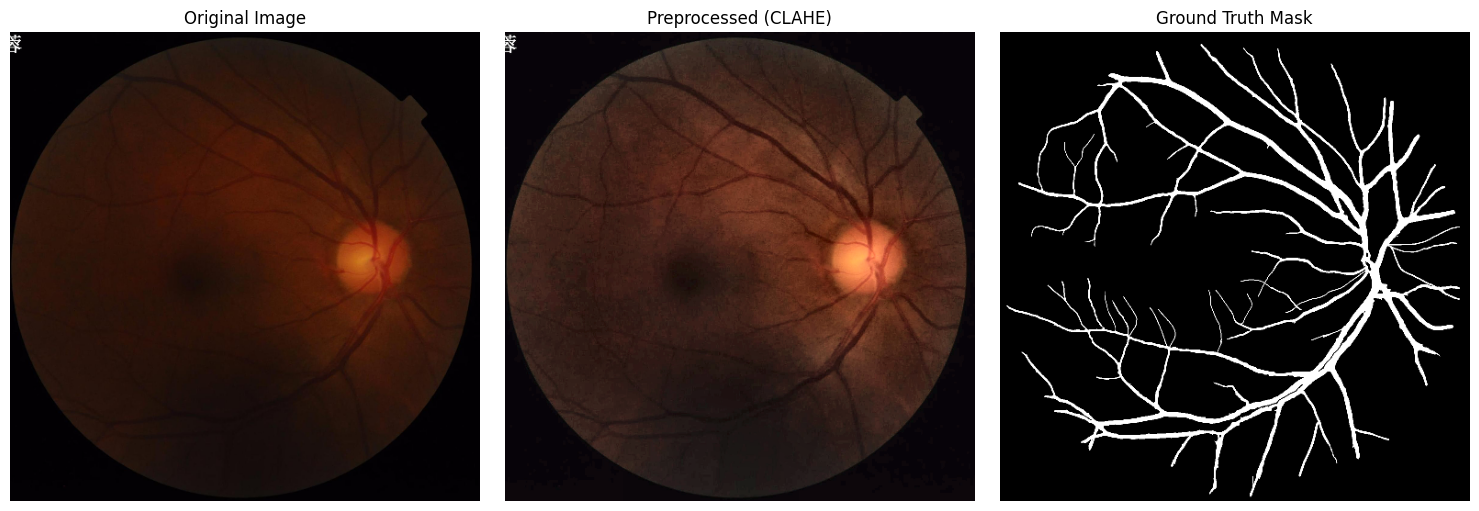

In [ ]:
# Step 3: Visualize sample data
sample_idx = random.randint(0, len(X_train) - 1)
display_sample(X_train[sample_idx], y_train[sample_idx], preprocessing=PREPROCESSING)

In [ ]:
# Step 4: Create data generators with enhanced augmentation
train_generator = data_sequence_generator(X_train, y_train, BATCH_SIZE, preprocessing=PREPROCESSING, is_training=True)
val_generator = data_sequence_generator(X_val, y_val, BATCH_SIZE, preprocessing=PREPROCESSING, is_training=False)

<ipython-input-32-8ec8ac514572>:17: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),


In [ ]:
# Step 5: Build model with enhanced backbone and custom loss
model = build_unet_model(BACKBONE, INPUT_SHAPE)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 256, 256, 64)   │          1,728 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 256, 256, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 256, 256, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 256, 256, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 256, 256, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 256, 256, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 64)       │          1,088 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 256, 256, 64)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 256, 256, 32)   │          2,048 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn   

 Total params: 75,048,097 (286.29 MB)

 Trainable params: 74,735,393 (285.09 MB)

 Non-trainable params: 312,704 (1.19 MB)

In [ ]:
# Step 6: Get callbacks with learning rate scheduler
callbacks = get_callbacks(MODEL_PATH)

In [ ]:
# Step 7: Train model
history = train_model(train_generator, val_generator, model, callbacks, EPOCHS)

Training model...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - binary_accuracy: 0.8982 - f1-score: 0.5034 - iou_score: 0.3560 - loss: 0.3399
Epoch 1: val_iou_score improved from -inf to 0.71877, saving model to models/model_best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 379s 651ms/step - binary_accuracy: 0.8983 - f1-score: 0.5036 - iou_score: 0.3562 - loss: 0.3396 - val_binary_accuracy: 0.9655 - val_f1-score: 0.8332 - val_iou_score: 0.7188 - val_loss: 0.1180 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009938503261272714.
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - binary_accuracy: 0.9450 - f1-score: 0.6525 - iou_score: 0.4998 - loss: 0.2132
Epoch 2: val_iou_score did not improve from 0.71877
209/209 ━━━━━━━━━━━━━━━━━━━━ 117s 554ms/step - binary_accuracy: 0.9450 - f1-score: 0.6525 - iou_score: 0.4997 - loss: 0.2133 - val_binary_accuracy: 0.9612 - val_f1-score: 0.8128 - val_iou_score: 0.6883 - val_loss: 0.1226 - learning_rate: 9.9385e-04

Epoch 3: LearningRate

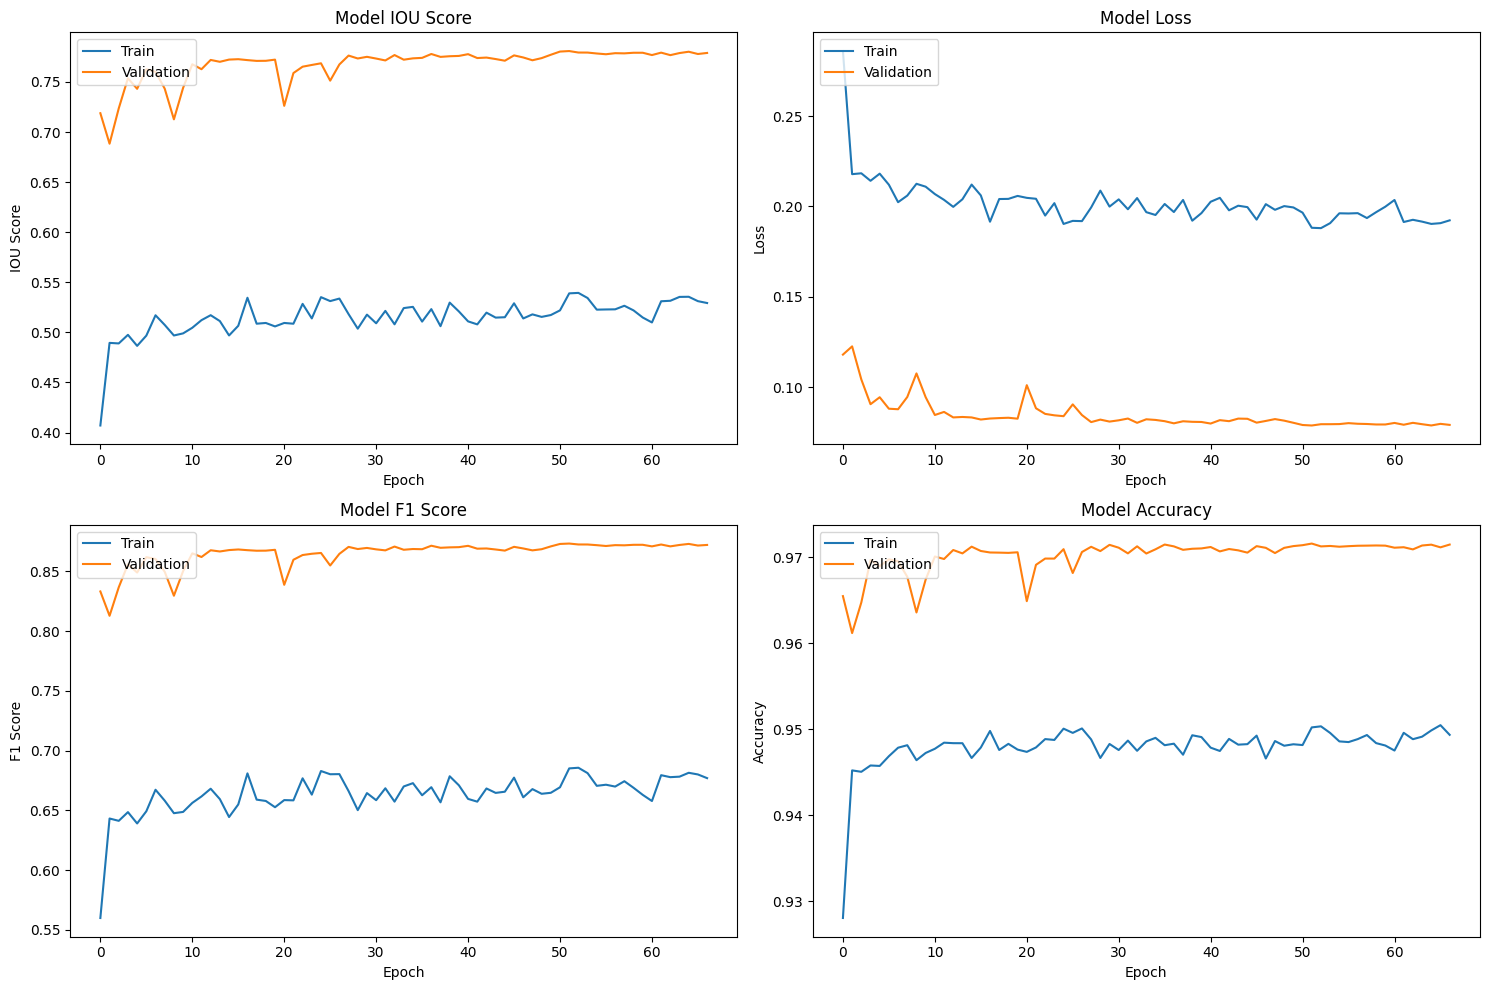

In [ ]:
# Step 8: Plot training history with enhanced metrics
plot_history(history)

In [ ]:
# Step 9: Save the final model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
final_model_path = os.path.join(MODEL_PATH, f"unet_{BACKBONE}_{timestamp}.h5")
model.save(final_model_path)
print(f"Final model saved at: {final_model_path}")

Final model saved at: models/unet_efficientnetb7_20250406_074439.h5


In [ ]:
# Step 10: Load the best model for evaluation
best_model_path = os.path.join(MODEL_PATH, "model_best.keras")
best_model = tf.keras.models.load_model(
    best_model_path,
    custom_objects={
        'dice_loss': dice_loss,
        'focal_loss': focal_loss,
        'dice_focal_loss': dice_focal_loss,
    },
    compile=False
)

In [ ]:
# Compile the model again with metrics
best_model.compile(
    optimizer='adam',
    loss=dice_focal_loss,
    metrics=[
        sm.metrics.IOUScore(threshold=0.5),
        sm.metrics.FScore(threshold=0.5),
        'accuracy'
    ]
)

In [ ]:
# Step 11: Evaluate on validation set
validation_results = evaluate_model(best_model, val_generator)

Evaluating model...
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.9689 - f1-score: 0.8628 - iou_score: 0.7657 - loss: 0.0852
Validation Loss: 0.0788
Validation IOU Score: 0.7808
Validation F-Score: 0.8732
Validation Accuracy: 0.9716


Performing detailed evaluation on validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Processed 10/210 validation samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Processed 20/210 validation samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/

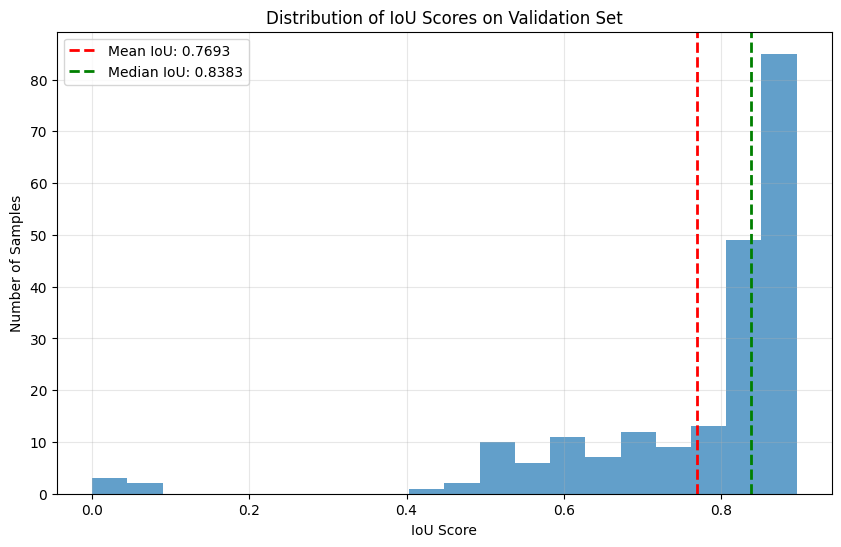

In [ ]:
# Step 12: Perform detailed evaluation
iou_scores = detailed_evaluation(best_model, X_val, y_val, preprocessing=PREPROCESSING)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


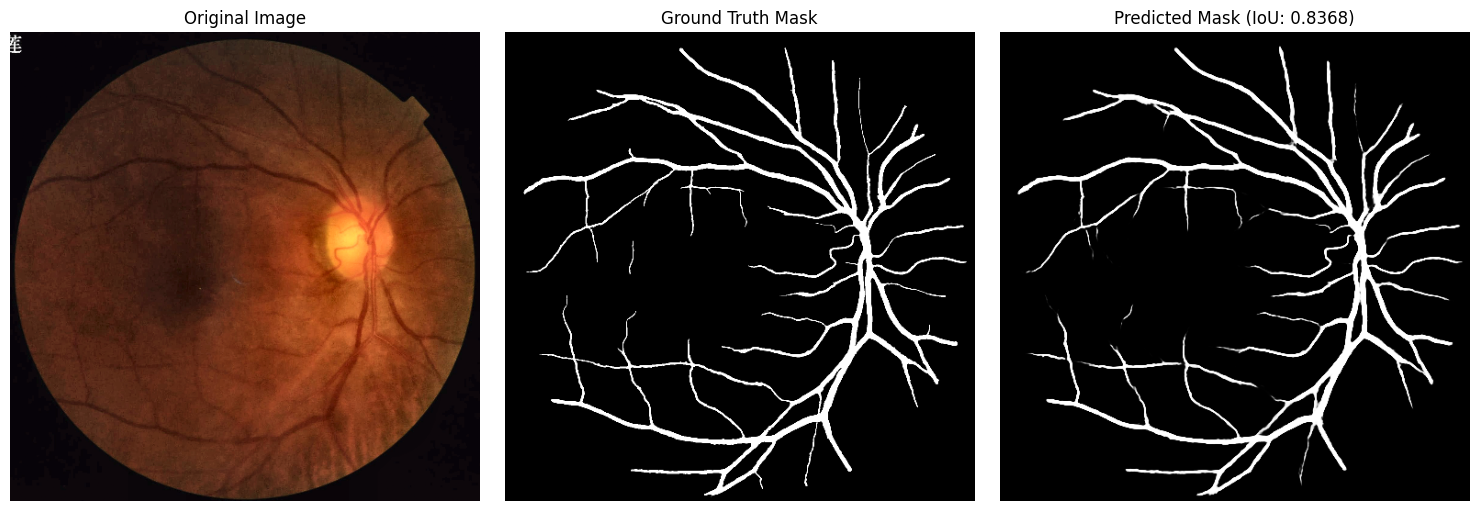

Sample IoU: 0.8368
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


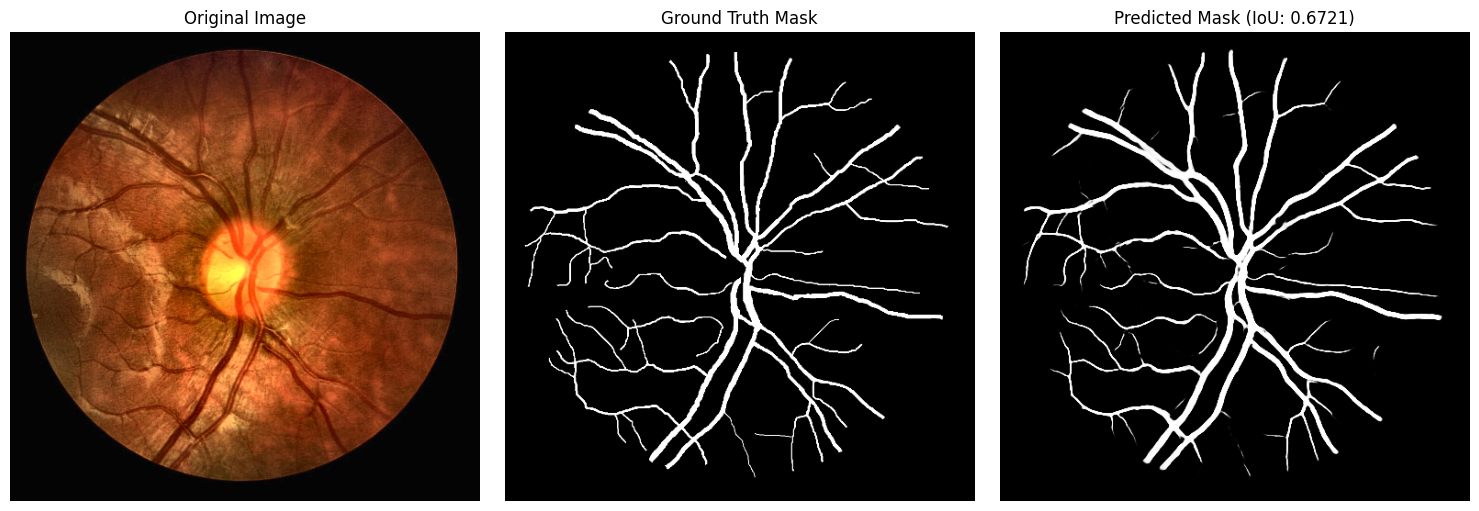

Sample IoU: 0.6721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


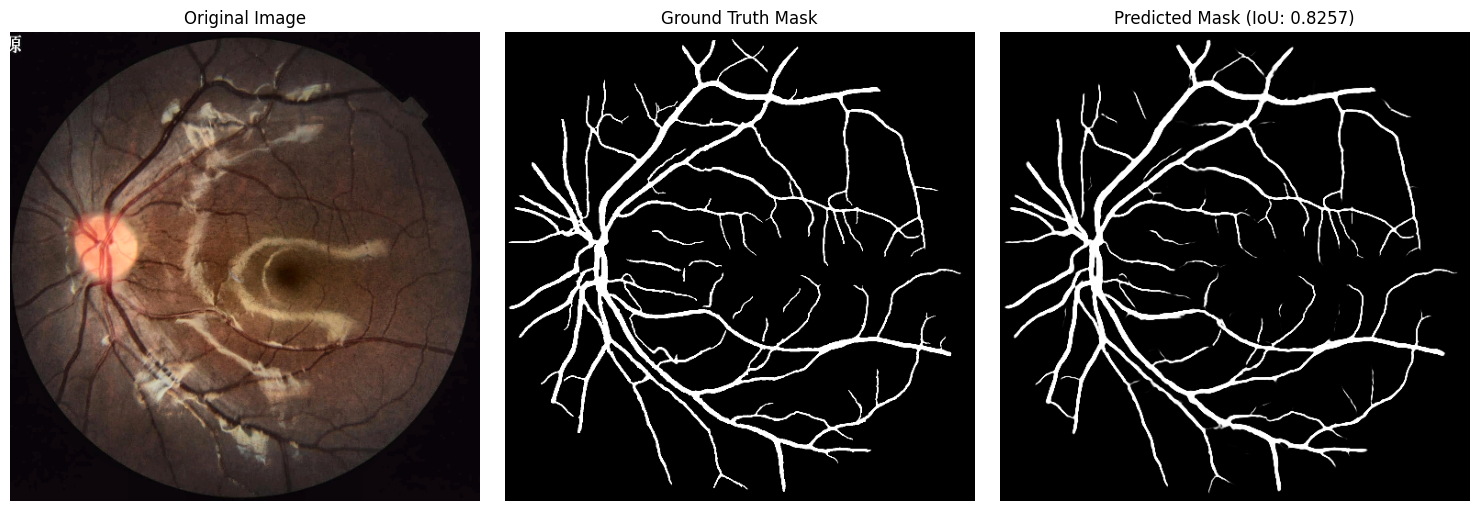

Sample IoU: 0.8257


In [ ]:
# Step 13: Display some predictions
for _ in range(3):
    sample_idx = random.randint(0, len(X_val) - 1)
    iou = display_prediction(best_model, X_val[sample_idx], y_val[sample_idx], preprocessing=PREPROCESSING)
    print(f"Sample IoU: {iou:.4f}")